# 快速入门：简单线性函数拟合

作者：[杨奕](https://github.com/helloyesterday)

[![下载Notebook](https://gitee.com/mindspore/docs/raw/tutorials-develop/resource/_static/logo_notebook.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/tutorials-develop/tutorials/zh_cn/mindspore_quick_start.ipynb)&emsp;[![下载样例代码](https://gitee.com/mindspore/docs/raw/tutorials-develop/resource/_static/logo_download_code.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/tutorials-develop/tutorials/zh_cn/mindspore_quick_start.py)&emsp;[![查看源文件](https://gitee.com/mindspore/docs/raw/tutorials-develop/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/tutorials-develop/tutorials/source_zh_cn/beginner/quick_start.ipynb)

## 概述

回归问题算法通常是利用一系列属性来预测一个值，预测的值是连续的。例如给出一套房子的一些特征数据，如面积、卧室数等等来预测房价，利用最近一周的气温变化和卫星云图来预测未来的气温情况等。如果一套房子实际价格为500万元，通过回归分析的预测值为499万元，则认为这是一个比较好的回归分析。

在机器学习问题中，常见的回归分析有线性回归、多项式回归、逻辑回归等。本章将使用深度学习的方法在MindSpore上拟合线性函数 $f(x) = 2x + 3$ 。

## 环境准备

设置MindSpore运行配置：

In [ ]:
from mindspore import context

# 设置模式为静态图模式，训练硬件为CPU
context.set_context(mode=context.GRAPH_MODE)

> 本教程后续代码依赖第三方支持包`matplotlib`和`IPython`，可使用命令`pip install matplotlib IPython`安装。

## 生成数据集

定义数据集生成函数 `get_data` ，生成训练数据集和测试数据集。

由于拟合的是线性数据，假定要拟合的目标函数为：$f(x)=2x+3$，那么我们需要的训练数据集应随机分布于函数周边，这里采用了$f(x)=2x+3+noise$的方式生成，其中`noise`为遵循标准正态分布规律的随机数值。

In [2]:
import numpy as np

def get_data(num, w=2.0, b=3.0):
    for _ in range(num):
        x = np.random.uniform(-10.0, 10.0)
        noise = np.random.normal(0, 1)
        y = x * w + b + noise
        yield np.array([x]).astype(np.float32), np.array([y]).astype(np.float32)

使用`get_data`生成50组验证数据，并可视化。

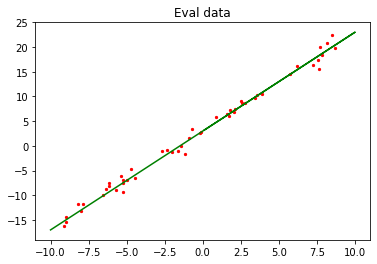

In [3]:
import matplotlib.pyplot as plt

eval_data = list(get_data(50))
x_target_label = np.array([-10, 10, 0.1])
y_target_label = x_target_label * 2 + 3
x_eval_label, y_eval_label = zip(*eval_data)

plt.scatter(x_eval_label, y_eval_label, color="red", s=5)
plt.plot(x_target_label, y_target_label, color="green")
plt.title("Eval data")
plt.show()

上图中绿色线条部分为目标函数，红点部分为验证数据`eval_data`。

## 加载数据集

加载数据集并对数据进行处理。

- `ds.GeneratorDataset`：将生成的数据转换为MindSpore的数据集，并且将生成的数据的x，y值存入到`data`和`label`的数组中。
- `batch`：将`batch_size`个数据组合成一个batch。
- `repeat`：将数据集数量倍增。

In [4]:
from mindspore import dataset as ds

def create_dataset(num_data, batch_size=16, repeat_size=1):
    input_data = ds.GeneratorDataset(list(get_data(num_data)), column_names=['data', 'label'])
    input_data = input_data.batch(batch_size, drop_remainder=True)
    input_data = input_data.repeat(repeat_size)
    return input_data

使用数据集增强函数生成训练数据，并查看训练数据的格式。

In [5]:
data_number = 1600
batch_number = 16
repeat_number = 1

ds_train = create_dataset(data_number, batch_size=batch_number, repeat_size=repeat_number)
print("The dataset size of ds_train:", ds_train.get_dataset_size())
dict_datasets = next(ds_train.create_dict_iterator())

print(dict_datasets.keys())
print("The x label value shape:", dict_datasets["data"].shape)
print("The y label value shape:", dict_datasets["label"].shape)

The dataset size of ds_train: 100
dict_keys(['data', 'label'])
The x label value shape: (16, 1)
The y label value shape: (16, 1)


通过定义的`create_dataset`将生成的1600个数据增强为了100组shape为16x1的数据集。

## 建立线性神经网络模型

在MindSpore中使用`nn.Dense`生成单个数据输入，单个数据输出的线性函数模型：

$$f(x)=wx+b\tag{1}$$

并使用Normal算子随机初始化权重$w$和$b$。

In [6]:
from mindspore.common.initializer import Normal
from mindspore import nn

class LinearNet(nn.Cell):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.fc = nn.Dense(1, 1, Normal(0.02), Normal(0.02))

    def construct(self, x):
        x = self.fc(x)
        return x

查看初始化的模型参数。

In [7]:
net = LinearNet()
model_params = net.trainable_params()
for param in model_params:
    print(param, param.asnumpy())

Parameter (name=fc.weight, shape=(1, 1), dtype=Float32, requires_grad=True) [[-0.01343766]]
Parameter (name=fc.bias, shape=(1,), dtype=Float32, requires_grad=True) [0.00548029]


初始化网络模型后，接下来将初始化的网络函数和训练数据集进行可视化，了解拟合前的模型函数情况。

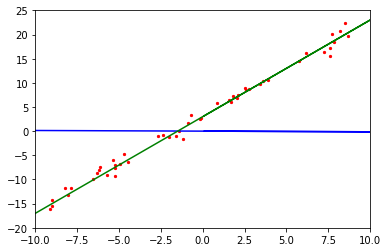

In [8]:
from mindspore import Tensor

x_model_label = np.array([-10, 10, 0.1])
y_model_label = (x_model_label * Tensor(model_params[0]).asnumpy()[0][0] +
                 Tensor(model_params[1]).asnumpy()[0])

plt.axis([-10, 10, -20, 25])
plt.scatter(x_eval_label, y_eval_label, color="red", s=5)
plt.plot(x_model_label, y_model_label, color="blue")
plt.plot(x_target_label, y_target_label, color="green")
plt.show()

从上图中可以看出，蓝色线条的初始化模型函数与绿色线条的目标函数还是有较大的差别的。

## 优化模型参数

神经网络定义好后，在前向传播过程中通过损失函数来计算神经网络的输出值与实际值的偏差；然后通过反向传播网络来更新模型参数，反向传播通过优化器函数使损失值最小来取得最优的模型参数。

### 定义损失函数

接下来需要定义模型的损失函数，这里采用均方误差（MSE，Mean Squared Error）的方法用于判断拟合的效果如何，即均方误差值越小，拟合的效果越好，其损失函数公式为：

$$J(w)=\frac{1}{m}\sum_{i=1}^m(h(x_i)-y^{(i)})^2\tag{2}$$

假设训练数据第$i$个数据为$(x_i,y^{(i)})$，公式2中的参数解释如下：

- $J(w)$为损失值。

- $m$为样本数据的数量，本例中$m$的值为`batch_number`。

- $h(x_i)$为第$i$个数据的$x_i$值代入模型网络（公式1）后的预测值。

- $y^{(i)}$为第$i$个数据中的$y^{(i)}$值（label值）。

In [9]:
net_loss = nn.MSELoss()

### 定义优化器

反向传播网络的目标是不断变换权重值，使得loss值取得最小值，一般的在线性网络中采用权重更新公式：

$$w_{t}=w_{t-1}-\alpha\frac{\partial{J(w_{t-1})}}{\partial{w}}\tag{3}$$

公式3参数解释如下：

- $w_{t}$为迭代后的权重值。
- $w_{t-1}$为迭代前的权重值。
- $\alpha$为学习率。
- $\frac{\partial{J(w_{t-1}\ )}}{\partial{w}}$为损失函数对权重$w_{t-1}$的微分。

函数中所有的权重值更新完成后，将值传入到模型函数中，这个过程就是反向传播过程，实现此过程需要使用MindSpore中的优化器函数，如下：

In [10]:
opt = nn.Momentum(net.trainable_params(), learning_rate=0.005, momentum=0.9)

### 构建完整网络

在MindSpore中需要调用`Model`函数，将前面定义的网络，损失函数，优化器函数关联起来，使之变成完整的计算网络。

In [11]:
from mindspore import Model

model = Model(net, net_loss, opt)

## 训练网络

为了使得整个训练过程更容易理解，需要将训练过程的测试数据、目标函数和模型网络进行可视化。需定义绘图函数和回调函数，在每个step训练结束后调用绘图函数，展示模型网络的拟合过程。

### 定义绘图函数

定义绘图函数 `plot_model_and_datasets` 绘制测试数据、目标函数和网络模型拟合函数。

In [12]:
import matplotlib.pyplot as plt
import time

def plot_model_and_datasets(net, eval_data):
    weight = net.trainable_params()[0]
    bias = net.trainable_params()[1]
    x = np.arange(-10, 10, 0.1)
    y = x * Tensor(weight).asnumpy()[0][0] + Tensor(bias).asnumpy()[0]
    x1, y1 = zip(*eval_data)
    x_target = x
    y_target = x_target * 2 + 3

    plt.axis([-11, 11, -20, 25])
    plt.scatter(x1, y1, color="red", s=5)
    plt.plot(x, y, color="blue")
    plt.plot(x_target, y_target, color="green")
    plt.show()
    time.sleep(0.2)

### 定义回调函数

MindSpore提供的工具，可对模型训练过程进行自定义控制，这里在`step_end`中调用可视化函数，展示拟合过程。 `display.clear_output`清除打印内容，实现动态拟合效果。

In [13]:
from IPython import display
from mindspore.train.callback import Callback

class ImageShowCallback(Callback):
    def __init__(self, net, eval_data):
        self.net = net
        self.eval_data = eval_data

    def step_end(self, run_context):
        plot_model_and_datasets(self.net, self.eval_data)
        display.clear_output(wait=True)

### 执行训练

完成以上过程后，可以使用训练数据`ds_train`对模型训练，这里调用`model.train`进行，参数解释如下：

- `epoch`：训练迭代的整个数据集的次数。
- `ds_train`：训练数据集。
- `callbacks`：训练过程中需要调用的回调函数。
- `dataset_sink_model`：数据集下沉模式，支持Ascend、GPU计算平台，本例为CPU计算平台设置为False。

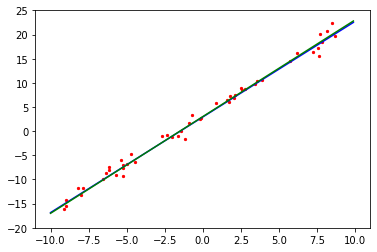

Parameter (name=fc.weight, shape=(1, 1), dtype=Float32, requires_grad=True) [[1.978053]]
Parameter (name=fc.bias, shape=(1,), dtype=Float32, requires_grad=True) [2.9263568]


In [14]:
epoch = 1
imageshow_cb = ImageShowCallback(net, eval_data)

model.train(epoch, ds_train, callbacks=[imageshow_cb], dataset_sink_mode=False)

plot_model_and_datasets(net, eval_data)
for net_param in net.trainable_params():
    print(net_param, net_param.asnumpy())

训练完成后打印出最终模型的权重参数，其中weight接近于2.0，bias接近于3.0，模型训练完成，符合预期。

## 保存及加载模型

将上述训练好的模型参数保存到CheckPoint(简称ckpt)文件中，然后将模型参数加载到网络中用于后续的预测。

In [16]:
from mindspore import save_checkpoint, load_checkpoint, load_param_into_net

# 将模型参数保存在ckpt文件
save_checkpoint(net, "./linear.ckpt")
# 将模型参数存入param_dict字典中
param_dict = load_checkpoint("./linear.ckpt")
# 查看模型参数
for param in param_dict:
    print(param, ":", param_dict[param].asnumpy())
# 将参数加载到网络中
load_param_into_net(net, param_dict)

fc.weight : [[1.978053]]
fc.bias : [2.9263568]


## 推理

使用 `model.predict` 预测输出结果。

In [18]:
from mindspore import dtype

# 预测输入为2的结果
pre_x = Tensor([[2]], dtype=dtype.float32)
pre_y = model.predict(pre_x)
print("predict result:", pre_y)

predict result: [[6.8824625]]


当输入为2时，代入公式$f(x) = 2x + 3$，理论输出为f(2)=7。预测输出非常接近7，符合预期。